## PyTorch Workflow

**Introduction to PyTorch Workflow**
34. Getting setup
35. Creating a dataset with linear regression
36. Creating training and test sets (the most important concept in ML)
38. Creating our first PyTorch model
40. Discussing important model building classes
41. Checking out the internals of our model
42. Making predictions with our model
43. Training a model with PyTorch (intuition building)
44. Setting up a loss function and optimizer
45. PyTorch training loop intuition
48. Running our training loop epoch by epoch
49. Writing testing loop code
51. Saving/loading a model
54. Putting everything together

In [1]:
import torch
from torch import nn # contains all pytorch building blocks for neural network
import matplotlib.pyplot as plt

In [2]:
# checking pytorch version
torch.__version__

'2.0.1+cu118'

## Data (preparing and loading)
In machine learning we have two main work:
1. Get data into numerical representation
2. Build a model to learn patterns in that numerical representation.

## Let's create data using linear regression:

In [3]:
# parameters:
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
x = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight*x+bias

In [4]:
x[:10],y[:10],len(x),len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

## Splitting data into training and test set

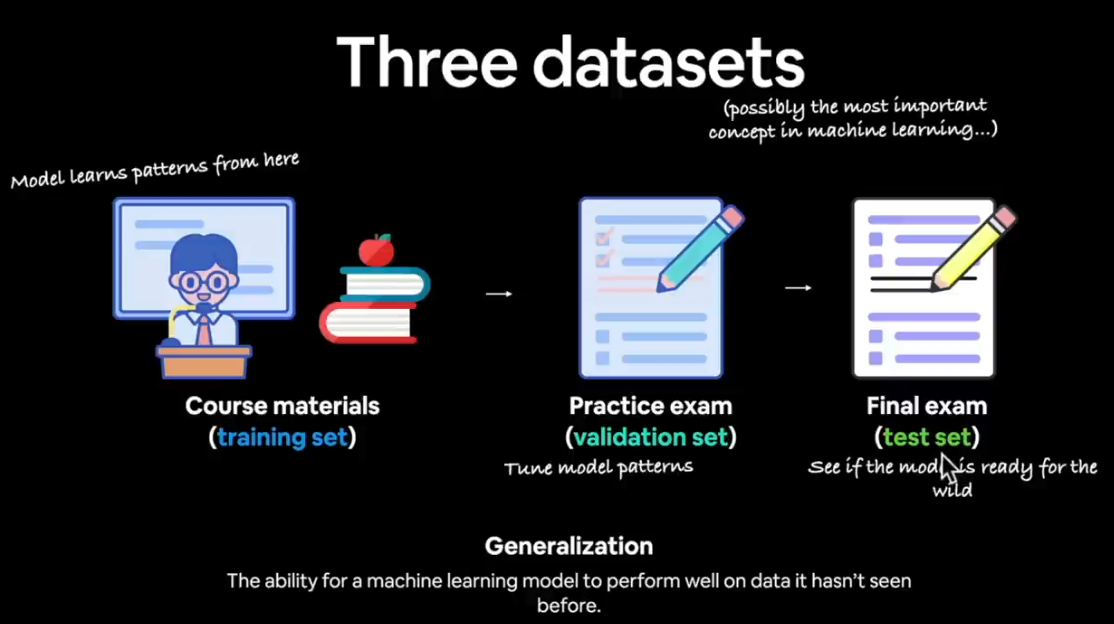

In [5]:
# create train-test split:
train_split = int(0.8*len(x))
x_train,y_train = x[:train_split],y[:train_split] # all till train_split
x_test, y_test  = x[train_split:],y[train_split:] # train_split onward.

In [6]:
len(x_train),len(x_test)

(40, 10)

# How might we visualize the result properly:

In [7]:
def plot_prediction(
    train_data = x_train,
    train_labels = y_train,
    test_data = x_test,
    test_labels = y_test,
    predictions = None
):
  """
  Plot training data, test data and compare prediction
  """
  plt.figure(figsize=(10,5))

  #plot training data in blue
  plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")
  #plot the test data in green:
  plt.scatter(test_data,test_labels,c="g",s=4,label="Testing data")

  # are these prediction
  if predictions is not None:
    # plot the predictions if they exist
    plt.scatter(test_data,predictions,c='r',s=4,label="prediction")
   #show the legend
  plt.legend(prop={'size':14})


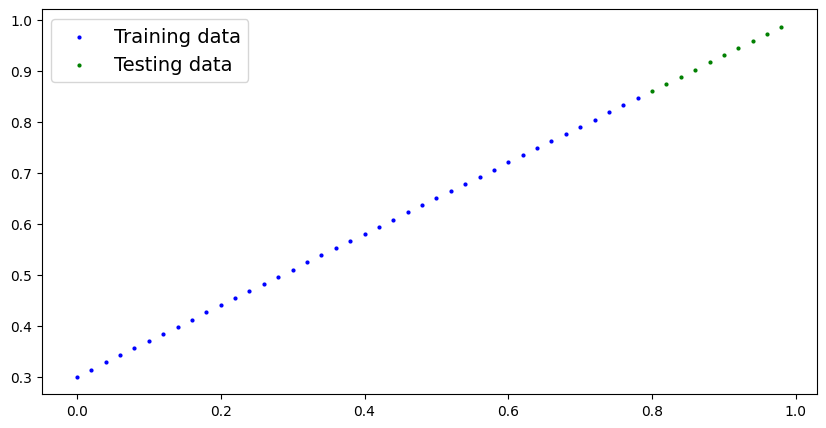

In [8]:
plot_prediction()

 # Creating model
 Our first PyTorch Model!!!
Python OOPS:
```
 https://realpython.com/python3-object-oriented-programming/
 ```

In [9]:
from torch import nn
# create a linear regression model class:
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherit from nn.Module
      def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

      # forward method: computation performed at every cell
      def forward(self,x): # x is the input data
         return self.weight*x + self.bias # linear regression formula

##PyTorch Model building essentials:
- `torch.nn`: contains all the building for computational graphs(a neural network)
- `torch.nn.Parameter`: what parameters should our model try with and learn(often a pytorch layer form torch.nn will set these)
- `torch.nn.Module`: base class for all neural network modules, if you subclass it, then overwrite forward()
- `torch.optim` : here optimizers in pytorch live, help with gradient descent
- `def.forward()` : All  `nn.Module` subclasses require you to overwrite forward(), it defines what happens in the forward computation.

# Checking the content of our PyTorch model
- Now we have created a model, let's see what's inside....
We can use `.parameters()` for this

In [10]:
# create a random seed
torch.manual_seed(42)

# create an instance of our model ( this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

In [11]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
# list named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

 ## Making prediction using `torch.inference_mode()`
 To check see our model's predictive power, let's see how well it preidcts y_test based on x_test.
 When we pass the data through our model, it's going to run through the forward() method

In [13]:
# make prediction with model
with torch.inference_mode():
  y_pred = model_0(x_test)
y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

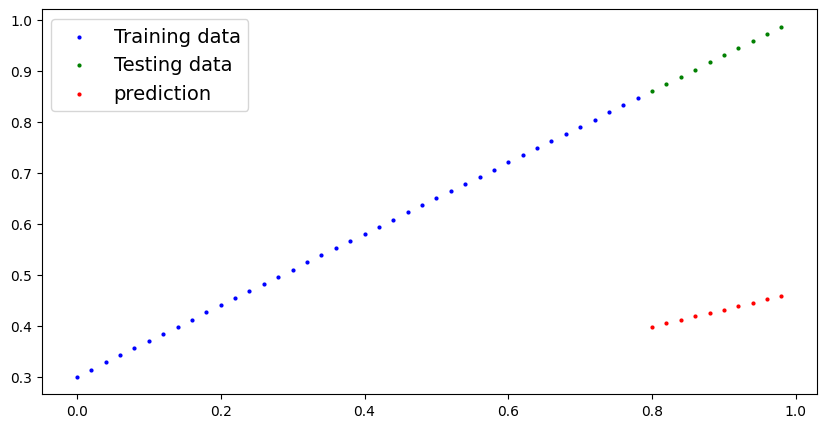

In [14]:
# let's see if the prediction of the model is correct or not.
plot_prediction(predictions=y_pred)

##### we see that the x_test data are not plotted accurately:
- since we started with random weights[0.3367] and bias[0.1288]
- ideal weight and bias were: [0.7,0.3]

*Aim*: to reach the ideal weight and bias:
```
(weight,bias) = [0.3367,0.1288] ===> [0.7,0.3]
```

# Above we used `Inference_mode`
- if we use y_pred = model_0(x_test) --> it will keep track of `grad` function
- and tracking grad unnecessarily reduce the predicition time.
- using inference_mode we stopped the gradient tracking.
- we can also use `torch.no_grad()` but inferernce mode has the advantages

# Now we'll try to move those parameters closer to the ideal values

# Train Model
The whole idea of training is for a model to move from some unknown parameters(may be random) to some known parameters.
Or poor representation ---> better representation.
How to measure the poverty of model?
-- Loss function/cost function or criterion.
Things we need to train:
- Loss function: A function to measure how wrong your model's prediciton are on the ideal output, less is better
- Optimizer: Takes the loss and adjust the model parameters.(weights, bias)

And specificially for PyTorch, we need
- A training loop
- A testing loop

In [15]:
# Set up a loss function
loss_fn = nn.L1Loss()

# setup an optimizer( stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)

 Q. which loss function and optimizer should I use?

 A: Problem specific,
    For regression: (`nn.L1Loss()`) and optimizer like `torch.optim.SGD` will suffice.
    For classification: (dog vs cat), loss function-(`nn.BCELoss()`)-binary cross entropy loss

## Building a training loop ( and a testing loop) in PyTorch
0. Loop through the data
1. Forward pass (this involve data moving through our model's  `forward()` function) to make prediction on the data.
2. Calculate the loss ( compare forward pass prediction to ground level truth)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each parameters of our model wrt the loss(**Backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss(**gradient descent**)

In [16]:
torch.manual_seed(42)
# An epoch is one loop through the data.
epochs = 1
# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train sets all the model parameters that require gradient.

  #1. forward pass
  y_pred = model_0(x_train)

  #2. calculate the loss
  loss = loss_fn(y_pred,y_train)

  #3. optimizer zero grad.
  optimizer.zero_grad()
  #4. backward propagation
  loss.backward()

  #5. step the optimizer (perform gradient descent)
  optimizer.step()


In [17]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])

In [18]:
with torch.inference_mode():
  y_preds_new = model_0(x_test)

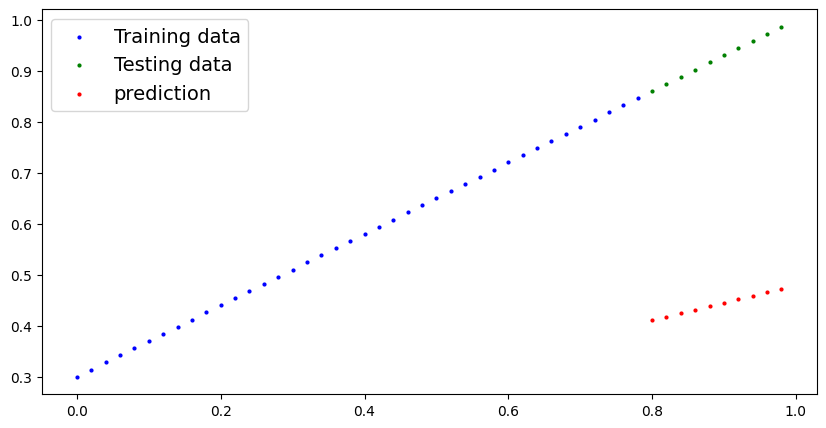

In [19]:
plot_prediction(predictions=y_preds_new)

#### If we increase the number of epochs and do all the optimization loop steps, the test data will move more closer to the original dataset.

In [20]:
# # let's do that.

# torch.manual_seed(42)
# # An epoch is one loop through the data.
# epochs = 100
# # 0. Loop through the data
# for epoch in range(epochs):
#   # set the model to training mode
#   model_0.train() # train sets all the model parameters that require gradient.

#   #1. forward pass
#   y_pred = model_0(x_train)

#   #2. calculate the loss
#   loss = loss_fn(y_pred,y_train)
#   #3. optimizer zero grad.
#   optimizer.zero_grad()
#   #4. backward propagation
#   loss.backward()

#   #5. step the optimizer (perform gradient descent)
#   optimizer.step()


In [21]:
# with torch.inference_mode():
#   y_preds_new = model_0(x_test)
# plot_prediction(predictions=y_preds_new)

In [22]:
# we see that the test data points moved closer to the ideal data output.

In [23]:
# model_0.state_dict()

In [24]:
#Also the weight and the bias moved closer to the ideal value of [0.7,0.3].

# testing

In [25]:
# The below code will carry on from 101th epoch (previous we ran for 100):
# Now we will see much lower losss and the plot of the x_test output will almost match the original data.

In [26]:
# let's do that.
epoch_count = []
loss_list = []
test_loss_list = []
torch.manual_seed(42)
# An epoch is one loop through the data.
epochs = 100
# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train sets all the model parameters that require gradient.

  #1. forward pass
  y_pred = model_0(x_train)

  #2. calculate the loss
  loss = loss_fn(y_pred,y_train)
  loss_list.append(loss)
  #3. optimizer zero grad.
  optimizer.zero_grad()
  #4. backward propagation
  loss.backward()

  #5. step the optimizer (perform gradient descent)
  optimizer.step()

  ### Testing:
  model_0.eval() # turns off different setting in the model not needed for evaluation.
  with torch.inference_mode():# turns off gradient tracking.
    #1. forward pass
    test_pred = model_0(x_test)

    #2. calcualte the loss
    test_loss = loss_fn(test_pred,y_test)
    test_loss_list.append(test_loss)

  # print out what's happening.
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {test_loss}")
    #Print out model state_dict()
    print(model_0.state_dict())

  epoch_count.append(epoch+1)




Epoch: 0 | Loss: 0.4675942063331604
OrderedDict([('weight', tensor([0.3445])), ('bias', tensor([0.1488]))])
Epoch: 10 | Loss: 0.3328842222690582
OrderedDict([('weight', tensor([0.3835])), ('bias', tensor([0.2488]))])
Epoch: 20 | Loss: 0.2069590985774994
OrderedDict([('weight', tensor([0.4222])), ('bias', tensor([0.3403]))])
Epoch: 30 | Loss: 0.14023718237876892
OrderedDict([('weight', tensor([0.4539])), ('bias', tensor([0.3788]))])
Epoch: 40 | Loss: 0.11182951927185059
OrderedDict([('weight', tensor([0.4768])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.09809747338294983
OrderedDict([('weight', tensor([0.4956])), ('bias', tensor([0.3838]))])
Epoch: 60 | Loss: 0.08776430785655975
OrderedDict([('weight', tensor([0.5134])), ('bias', tensor([0.3783]))])
Epoch: 70 | Loss: 0.0794917643070221
OrderedDict([('weight', tensor([0.5306])), ('bias', tensor([0.3713]))])
Epoch: 80 | Loss: 0.07190609723329544
OrderedDict([('weight', tensor([0.5475])), ('bias', tensor([0.3638]))])
Epoch: 90 | Los

In [27]:
# we see that the loss reduced very low.

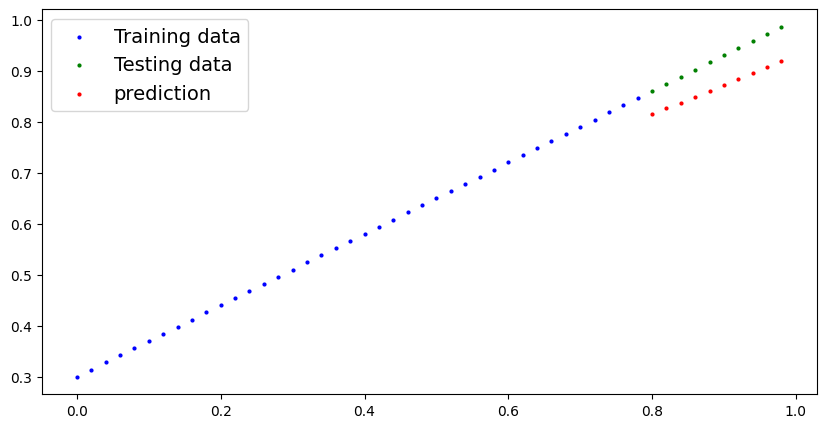

In [28]:
with torch.inference_mode():
  y_preds_new = model_0(x_test)
plot_prediction(predictions=y_preds_new)

## Error: data type:
1. we can't directly plot loss_list as it is having gradient history.
2. So we need to change it to numpy array: np.array(torch.tensor(x).numpy())
3. For test loss we had turned off the gradient tracking so no need for that.

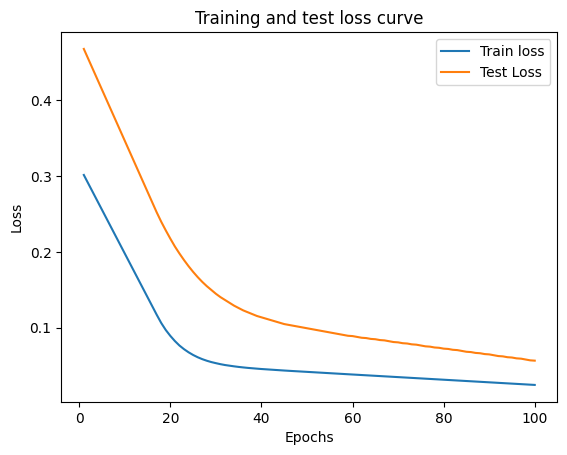

In [29]:
# visualizing the losses:
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_list).numpy()), label ="Train loss")
plt.plot(epoch_count, test_loss_list, label = "Test Loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();
plt.show()

In [30]:
# if we increase the epochs the loss function will converge towards 0.

# Saving a model in PyTorch

In [31]:
# every time the colab is disconnected we need to run them all again.
# so its good to save the model and use it whenever needed.

`torch.save()`
`torch.load()`

In [32]:
# SAVING THE PYTORCH MODEL.
from pathlib import Path
# 1. create model directory.
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH  = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model ot: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)


Saving model ot: models/01_pytorch_workflow_model_0.pth


# Loading the model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved  `state_dict()` into that

In [33]:
model_0.state_dict()
# this is the model-saved parameters.

OrderedDict([('weight', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [34]:
# TO load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() of model_0 ( this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [35]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [36]:
# Mathced the weights and bias.

In [37]:
# Make some prediction with our loaded model.
# Evaluation Mode
loaded_model_0.eval()
# Inference mode.
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(x_test)

loaded_model_preds

tensor([[0.8143],
        [0.8259],
        [0.8375],
        [0.8491],
        [0.8607],
        [0.8723],
        [0.8839],
        [0.8955],
        [0.9071],
        [0.9187]])

In [38]:
# original model preds.
model_0.eval()
with torch.inference_mode():
  org_preds = model_0(x_test)

org_preds

tensor([[0.8143],
        [0.8259],
        [0.8375],
        [0.8491],
        [0.8607],
        [0.8723],
        [0.8839],
        [0.8955],
        [0.9071],
        [0.9187]])

In [39]:
loaded_model_preds == org_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [40]:
## Both the predictions match.

## 6. Putting it all Together
Let's code back through all the steps above and see all at one place

In [41]:
# import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# check the version of pytorch
torch.__version__

'2.0.1+cu118'

# Create Device-agnostic code
Using GPU  if its available

In [42]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Data

In [43]:
# Create some data using Linear Regression forumla.
# y = bX+c ( weight*x + biax)
weight = 0.7
bias  = 0.3

# create range values.
start = 0
end = 1
step = 0.02

# create x and y (feature and label)
x = torch.arange(start, end, step)
# shape of x is [50] but we need it in [50,1]: later we'll get error of matrix maultiplication.
x = x.unsqueeze(dim = 1)
y = weight*x + bias
x[:10], y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [44]:
x.shape

torch.Size([50, 1])

In [45]:
# split the data
train_split = int(0.8*len(x))
x_train,y_train = x[:train_split],y[:train_split]
x_test, y_test = x[train_split:],y[train_split:]
len(x_train),len(x_test)

(40, 10)

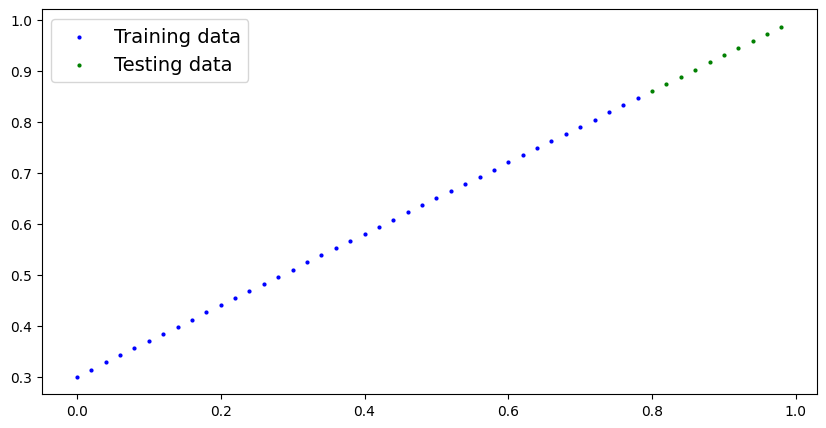

In [46]:
# plot using plot prediction functoin.
plot_prediction(x_train,y_train,x_test,y_test)

# Building PyTorch Linear model

In [47]:
# create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.Linear() for creating the model parameters / also called linear transform, probing layer, fully connected layer, dense layer.
    self.linear_layer = nn.Linear(in_features=1,out_features=1)

  # will return weight*x+bias, but it need only x to be provided, other params have been defined by Linear layer.
  def forward(self,x):
    return self.linear_layer(x)

Here, the `forward(x)` method takes `x` and do the following transformation: A' and b are already initialized by the linear layer.
so self.linear_layer which is an object of nn.Linear() takes the x and do the computation.

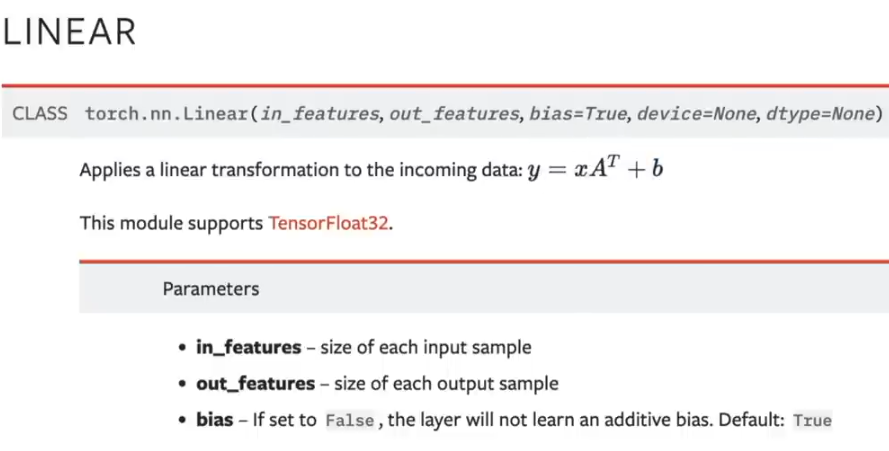

In [48]:
# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [49]:
# Weight and bias has been initialized according to our x data.

In [50]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [51]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

# Training

# For training we need:
1. Loss function
2. Optimizer
3. Training Loop
4. Testing loop

In [52]:
# loss function
loss_fn = nn.L1Loss() # MAE

# setup optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),lr = 0.01)

In [53]:
# let's write the training loop
torch.manual_seed(42)
epochs = 200

# we need to put all the data on the device: got error of device.
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
  model_1.train()

  #1. forward pass
  y_pred = model_1(x_train)

  #2. Loss function
  loss = loss_fn(y_pred,y_train)

  # 0 gradient
  optimizer.zero_grad()
  # backward
  loss.backward()
  # step step step
  optimizer.step()

  ## TESTING:::

  model_1.eval()

  with torch.inference_mode():
    # 1 forward pass
    test_pred = model_1(x_test)
    # 2. loss function
    test_loss = loss_fn(test_pred,y_test)

  # Print out what's happening.
  if epoch%10==0:
    print(f"Epoch : {epoch+1} || Train loss: {loss} || Test loss: {test_loss}")

Epoch : 1 || Train loss: 0.5551779866218567 || Test loss: 0.5739762187004089
Epoch : 11 || Train loss: 0.439968079328537 || Test loss: 0.4392664134502411
Epoch : 21 || Train loss: 0.3247582018375397 || Test loss: 0.30455657839775085
Epoch : 31 || Train loss: 0.20954833924770355 || Test loss: 0.16984669864177704
Epoch : 41 || Train loss: 0.09433845430612564 || Test loss: 0.03513690456748009
Epoch : 51 || Train loss: 0.023886388167738914 || Test loss: 0.04784907028079033
Epoch : 61 || Train loss: 0.019956795498728752 || Test loss: 0.045803118497133255
Epoch : 71 || Train loss: 0.016517987474799156 || Test loss: 0.037530567497015
Epoch : 81 || Train loss: 0.013089174404740334 || Test loss: 0.02994490973651409
Epoch : 91 || Train loss: 0.009653178043663502 || Test loss: 0.02167237363755703
Epoch : 101 || Train loss: 0.006215683650225401 || Test loss: 0.014086711220443249
Epoch : 111 || Train loss: 0.00278724217787385 || Test loss: 0.005814164876937866
Epoch : 121 || Train loss: 0.001264503

In [54]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

# Making prediction and plot

In [55]:
# turn model evaluation mode.
model_1.eval()

# make prediction on test data.
with torch.inference_mode():
  y_pred_new = model_1(x_test)
y_pred_new  # the result is on cuda device.

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

* Error: Device error :*

put the y_pred on cpu, because plot function use numpy and work on cpu

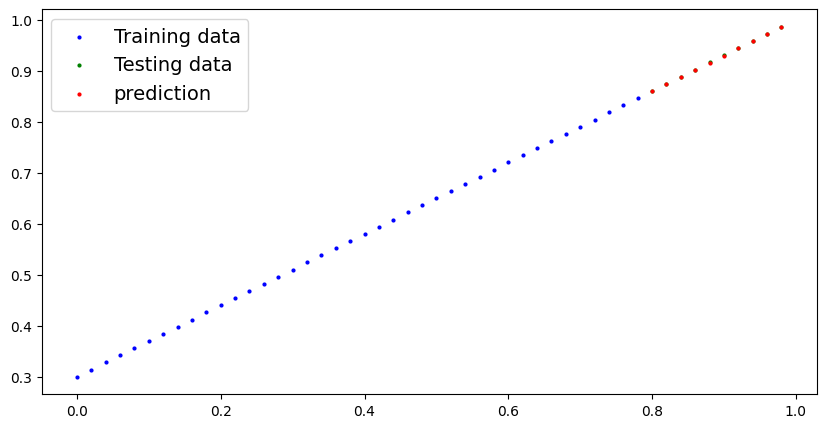

In [56]:
# check out the model predictions visually.
plot_prediction(predictions = y_pred_new.cpu())

## Save and load the model

In [57]:
from pathlib import Path
# create  model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok =True)

# create model path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH  = MODEL_PATH / MODEL_NAME


# save the model state dict (not the whole model)
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
          f = MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_1.pth


In [58]:
# load the pytorch saved model
# create a new instance of Lienar regression model v2
loaded_model_1 = LinearRegressionModelV2()

# load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [59]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [60]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [61]:
# Evaluating the loaded model.
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_pred = loaded_model_1(x_test)

y_pred_new == loaded_model_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [62]:
# both the prediction matched.

## Exercises

## Task 1:
1. Create a straight line dataset using the linear regression formula (weight * X + bias).
2. Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
3. Split the data into 80% training, 20% testing.
4. Plot the training and testing data so it becomes visual.

In [63]:
import torch
# 1,2. create straight line dataset.
weight = 0.3
bias = 0.9

start = 0
end = 1
step = 0.01
x = torch.arange(start, end, step).unsqueeze(dim = 1) # we need it in [100,1] form
y = weight*x + bias

In [64]:
x.shape,y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [65]:
# 3. split data 80-20%.
train_split = int(len(x)*0.8)
x_train = x[:train_split]
y_train = y[:train_split]
x_test  = x[train_split:]
y_test = y[train_split:]

In [66]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

(torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]))

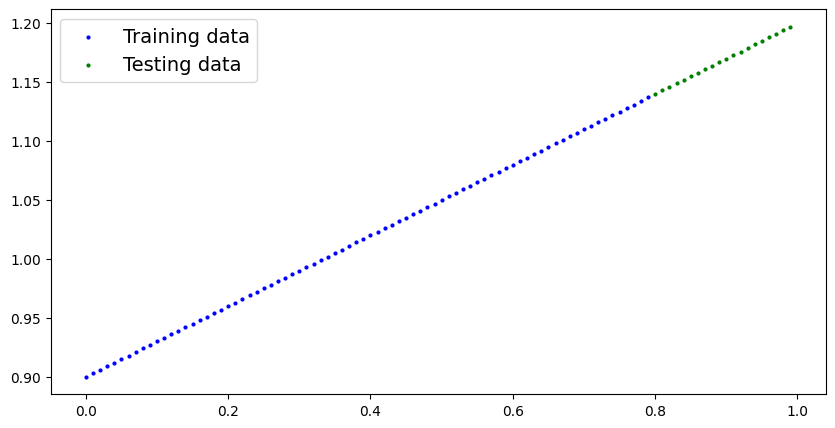

In [67]:
plot_prediction(x_train,y_train,x_test,y_test)

## Task 2
1. Build a PyTorch model by subclassing nn.Module.
2. Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
3. Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
4. Once you've constructed the model, make an instance of it and check its state_dict().
Note: If you'd like to use nn.Linear() instead of nn.Parameter() you can.

In [68]:
# Pytorch model
class Exercise_Lin_Reg(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features =1,out_features=1)

  # forward method.
  def forward(self,x):
    return self.linear_layer(x)

In [69]:
# 4. making an instance of pytorch model.
ex_model = Exercise_Lin_Reg()
ex_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2343]])),
             ('linear_layer.bias', tensor([0.9186]))])

## Task: 3
1. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.
2. Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
3. Write a training loop to perform the appropriate training steps for 300 epochs.
4. The training loop should test the model on the test dataset every 20 epochs.

In [70]:
# loss function
loss_fn = nn.L1Loss() # MAE
# optimizer
optimizer = torch.optim.SGD(params=ex_model.parameters(),lr = 0.01)

In [71]:
# Training loop: Optimizer sonnnnnnnnnnnggggggggggggggggg.
epochs = 300

for epoch in range(epochs):
  # train model
  ex_model.train()

  # 1. forward pass
  y_pred_ex = ex_model(x_train)
  # 2. loss function
  loss_ex = loss_fn(y_pred_ex,y_train)
  # 0 gradient
  optimizer.zero_grad()
  # backward
  loss_ex.backward()
  # optimizer step step step
  optimizer.step()

  ## TESTING:

  ex_model.eval()
  with torch.inference_mode():
    # forward pass
    y_pred_ex_test = ex_model(x_test)
    # loss calculation
    loss_ex_test = loss_fn(y_pred_ex_test,y_test)

  # Printing what's happeining
  if epoch % 20 == 0:
    print(f"Epoch: {epoch+1} | Train loss: {loss_ex} | Test loss: {loss_ex_test}")



Epoch: 1 | Train loss: 0.1934860348701477 | Test loss: 0.44704073667526245
Epoch: 21 | Train loss: 0.099742591381073 | Test loss: 0.2774539589881897
Epoch: 41 | Train loss: 0.08286076784133911 | Test loss: 0.20952367782592773
Epoch: 61 | Train loss: 0.07524622231721878 | Test loss: 0.17951278388500214
Epoch: 81 | Train loss: 0.06834527105093002 | Test loss: 0.16077637672424316
Epoch: 101 | Train loss: 0.06149417161941528 | Test loss: 0.1444476842880249
Epoch: 121 | Train loss: 0.05464210361242294 | Test loss: 0.12846292555332184
Epoch: 141 | Train loss: 0.0477910041809082 | Test loss: 0.11213425546884537
Epoch: 161 | Train loss: 0.040939826518297195 | Test loss: 0.09580682963132858
Epoch: 181 | Train loss: 0.03408767282962799 | Test loss: 0.07982330024242401
Epoch: 201 | Train loss: 0.027236470952630043 | Test loss: 0.06349574029445648
Epoch: 221 | Train loss: 0.020384784787893295 | Test loss: 0.04734015464782715
Epoch: 241 | Train loss: 0.013533586636185646 | Test loss: 0.031012600287

# Task 4:
1. Make predictions with the trained model on the test data.
2. Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [72]:
# Making prediction.
ex_model.eval()
with torch.inference_mode():
  y_pred_test_data = ex_model(x_test)


In [73]:
y_pred_test_data.shape

torch.Size([20, 1])

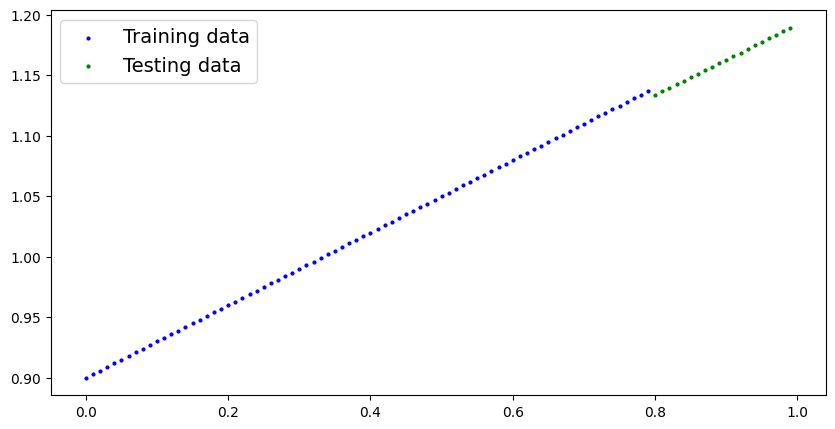

In [74]:
plot_prediction(x_train,y_train, x_test,y_pred_test_data)

# Save and load the model